**Experiment Details**:

52146 - 2 training sims, 1000 iterations, not so good for the other training sim, struggles to converge.

96778 - all sims but too slow, 10 batch time, 6 batch size, 7 sims per batch, 60 epochs, 500 iters

73102 - reduce niters per epoch and reduce sims per batch to aggregate as well as batch time, since integration to final time step can be slower for adaptive solver. 3 sims per batch and 60 epochs, 150 iters per epoch.

Next - 150 epochs at least, split into train test and calibration set. 250 iters. 4 sims per batch, one more layer in the network.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import pandas as pd

In [3]:
import re
import os
import time

In [4]:
import matplotlib.pyplot as plt
import argparse
import logging

In [5]:
# SPECIFY ARGS
# Generative model for noisy data based on ODE
parser = argparse.ArgumentParser('PNODE')

# parser.add_argument('-n',  type=int, default=1, help="Size of the dataset")
# parser.add_argument('-n',  type=int, default=100, help="Size of the dataset")

parser.add_argument('--niters', type=int, default=200)
parser.add_argument('--lr',  type=float, default=1e-3, help="Starting learning rate.")
parser.add_argument('-bs', '--batch-size', type=int, default=4)
parser.add_argument('-bt', '--batch-time', type=int, default=5)
parser.add_argument('-nspb', '--nsims_per_batch', type=int, default=4)
parser.add_argument('-epch', '--nepochs', type=int, default=250)


parser.add_argument('--save', type=str, default='experiments/', help="Path for save checkpoints")
parser.add_argument('--load', type=str, default=39492, help="ID of the experiment to load for evaluation. If None, run a new experiment.")
parser.add_argument('-r', '--random-seed', type=int, default=1123, help="Random_seed")


parser.add_argument('--pnode', 
                    action='store_false', 
                    help="RUN parameterized neural ode")
parser.add_argument('--node-layers', 
                    type=int, 
                    default=3, 
                    help="number of layers in NODE")

parser.add_argument('-u', '--units', 
                    type=int, 
                    default=70, 
                    help="Number of units per layer in ODE func")

# parser.add_argument('--normalize', type=bool, default=True)

parser.add_argument('-ds',
                    type=int,
                    default=4,
                    help="Coarsening factor for position angles")

args = parser.parse_args(args=())

In [6]:
vars(args)

{'niters': 200,
 'lr': 0.001,
 'batch_size': 4,
 'batch_time': 5,
 'nsims_per_batch': 4,
 'nepochs': 250,
 'save': 'experiments/',
 'load': 39492,
 'random_seed': 1123,
 'pnode': True,
 'node_layers': 3,
 'units': 70,
 'ds': 4}

In [7]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from random import SystemRandom

In [8]:
%matplotlib inline

In [9]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [11]:
!pip install --user -q torchdiffeq

In [12]:
adjoint=True
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
import edge_utils as edut
import node_1d_utils as nut

In [15]:
import logging

# stealing this from: 
# https://github.com/rtqichen/torchdiffeq/blob/master/examples/odenet_mnist.py#L250C1-L274C18
def get_logger(logpath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
        #     logger.info(filepath)

        #     with open(filepath, "r") as f:
        #         logger.info(f.read())

        #     for f in package_files:
        #         logger.info(f)
        #         with open(f, "r") as package_f:
        #             logger.info(package_f.read())

    return logger

In [16]:
edut.makedirs(os.path.join(os.getcwd(), "logs"))
logdir = os.path.join(os.getcwd(), "logs")

In [17]:
theta_s_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360
theta_e_2161 = np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [18]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)
# crude downsample for now
ed_2161 = ed_2161[:, ::args.ds, :]

In [19]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 40, 278)

In [20]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161 * args.ds)[::args.ds]
theta_grid

array([-31.        , -28.1572327 , -25.31446541, -22.47169811,
       -19.62893082, -16.78616352, -13.94339623, -11.10062893,
        -8.25786164,  -5.41509434,  -2.57232704,   0.27044025,
         3.11320755,   5.95597484,   8.79874214,  11.64150943,
        14.48427673,  17.32704403,  20.16981132,  23.01257862,
        25.85534591,  28.69811321,  31.5408805 ,  34.3836478 ,
        37.22641509,  40.06918239,  42.91194969,  45.75471698,
        48.59748428,  51.44025157,  54.28301887,  57.12578616,
        59.96855346,  62.81132075,  65.65408805,  68.49685535,
        71.33962264,  74.18238994,  77.02515723,  79.86792453])

In [21]:
def getRValuesAllSims(edge_data_matrix, sample_freq=2):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0, sample_freq=sample_freq)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [22]:
rd_2161 = getRValuesAllSims(ed_2161, sample_freq=4)

In [23]:
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

In [24]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [25]:
from numpy.random import Generator, PCG64
# rng = Generator(PCG64())
rng = np.random.default_rng(seed=202310)

nTrain = int(np.floor(0.7 * len(sd_modified)))
nCalib = int(np.floor(0.15 * len(sd_modified)))
nTest = len(sd_modified) - nTrain - nCalib

print(nTrain, nCalib, nTest)

sd_train = np.sort(rng.choice(sd_modified, nTrain, replace=False))
sd_calib = np.sort(rng.choice(np.setdiff1d(sd_modified, sd_train), nCalib, replace=False))
sd_test = np.setdiff1d(sd_modified, np.sort(np.concatenate((sd_train, sd_calib), axis=0)))

183 39 40


In [26]:
sd_train

array([ 31,  32,  34,  37,  38,  40,  41,  44,  45,  46,  49,  50,  51,
        53,  54,  56,  57,  58,  59,  61,  62,  67,  69,  70,  71,  72,
        75,  76,  77,  78,  79,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  97,  98, 101, 103, 104, 105, 107,
       110, 111, 112, 115, 118, 120, 123, 126, 127, 132, 134, 135, 136,
       138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 150, 151, 152,
       153, 154, 155, 156, 157, 159, 160, 161, 163, 164, 166, 171, 172,
       173, 175, 176, 177, 178, 180, 183, 184, 185, 190, 191, 192, 198,
       199, 201, 202, 203, 204, 205, 206, 213, 214, 215, 216, 217, 219,
       220, 221, 222, 223, 224, 226, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 238, 239, 240, 241, 242, 243, 246, 247, 249, 251, 252,
       254, 255, 259, 260, 261, 265, 269, 271, 274, 275, 276, 278, 280,
       281, 282, 283, 284, 286, 288, 290, 293, 294, 295, 296, 299, 300,
       303, 305, 307, 314, 316, 317, 318, 319, 321, 322, 326, 32

In [27]:
sd_calib

array([ 36,  42,  47,  48,  52,  60,  64,  65,  74,  80, 100, 102, 121,
       129, 130, 149, 162, 168, 169, 179, 196, 197, 209, 210, 211, 225,
       227, 262, 263, 272, 289, 291, 297, 298, 301, 304, 315, 320, 325])

In [28]:
sd_test

array([ 35,  43,  66,  68,  81,  96,  99, 106, 108, 114, 119, 122, 124,
       133, 158, 174, 181, 186, 188, 194, 200, 208, 212, 237, 244, 248,
       256, 257, 258, 266, 267, 268, 277, 279, 287, 292, 302, 306, 311,
       323])

In [29]:
# sd_track_train_error = np.array([31, 42, 50, 71, 80]) # when only train-test split.
sd_track_train_error = np.array([31, 44, 50, 71, 86])

In [30]:
modified_sd_train_idx = np.array([np.where(sd_modified == i)[0][0] for i in sd_train])

In [31]:
orig_sd_track_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_track_train_error])
orig_sd_track_idx

array([ 0, 13, 19, 39, 54])

In [32]:
orig_sd_train_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_train])
orig_sd_test_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_test])

In [33]:
y_train = rd_2161[:, :, orig_sd_train_idx]
y_test = rd_2161[:, :, orig_sd_test_idx]

y_train.shape, y_test.shape

((90, 40, 183), (90, 40, 40))

In [68]:
y_calib = rd_2161[:, :, orig_sd_calib_idx]
y_calib.shape

(90, 40, 39)

In [34]:
# LOOP TO EXTRACT DT, TMIN, TMAX VALUES. BASED ON THESE, store min and max of training
# data and use that to normalize train and test sets.

tMinTrain = []
tMaxTrain = []

tMinTrainIdx=[]
tMaxTrainIdx=[]

dtTrain = []
yMinTrain = []
yMaxTrain = []

tMinTest = []
tMaxTest = []
dtTest = []

for sidx in orig_sd_train_idx:
    
    r_sim = rd_2161[:, :, sidx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = sidx)

    r_sim_valid = r_sim[tMinIdx:(tMaxIdx + 1), :]
    
    tMinTrain.append(tMin)
    tMaxTrain.append(tMax)

    tMinTrainIdx.append(tMinIdx)
    tMaxTrainIdx.append(tMaxIdx)

    
    yMinTrain.append(r_sim_valid.min())
    yMaxTrain.append(r_sim_valid.max())
    
    tAllScaled = (np.arange(tMin, tMax + 2, step=2) - tMin) / (tMax - tMin)
    
    dtTrain.append(tAllScaled[1] - tAllScaled[0])
    
    
for sidx in orig_sd_test_idx:
    
    r_sim = rd_2161[:, :, sidx]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = sidx)

    r_sim_valid = r_sim[tMinIdx:(tMaxIdx + 1), :]
    
    tMinTest.append(tMin)
    tMaxTest.append(tMax)
        
    tAllScaled = (np.arange(tMin, tMax + 2, step=2) - tMin) / (tMax - tMin)
    
    dtTest.append(tAllScaled[1] - tAllScaled[0])

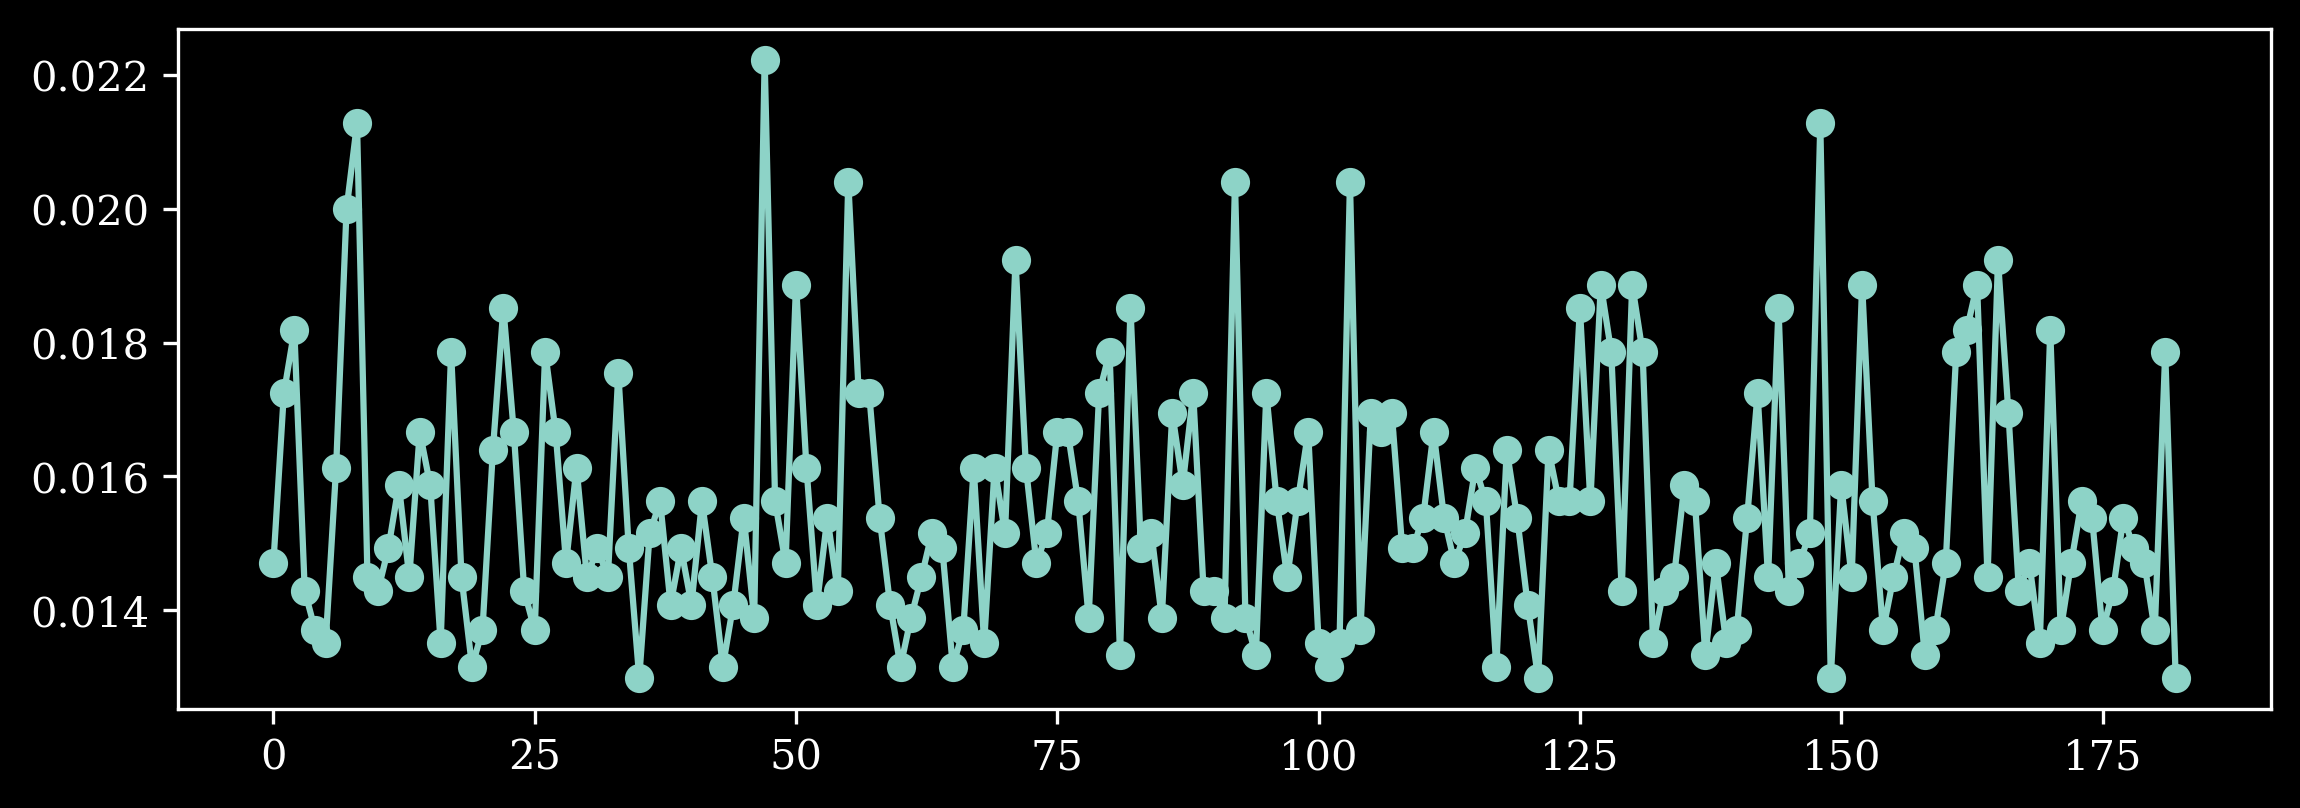

In [35]:
# plot dt for train
plt.plot(dtTrain, marker='o')

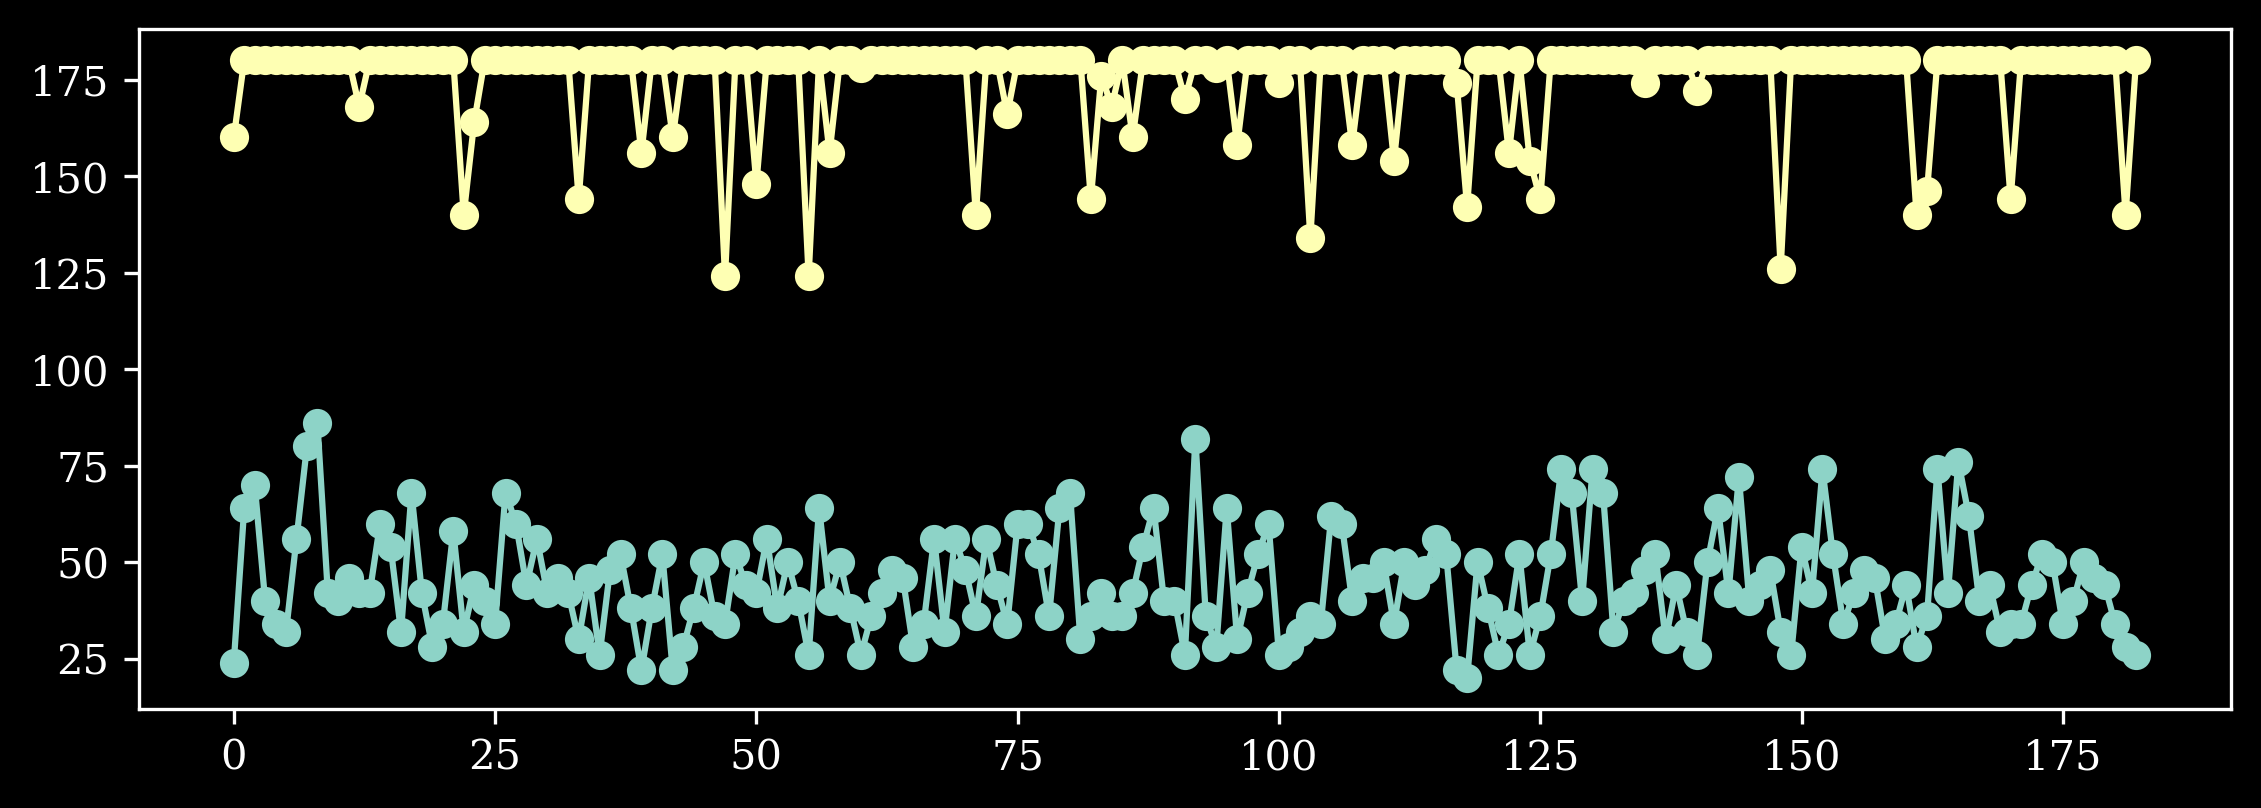

In [36]:
plt.plot(tMinTrain, marker='o')
plt.plot(tMaxTrain, marker='o')

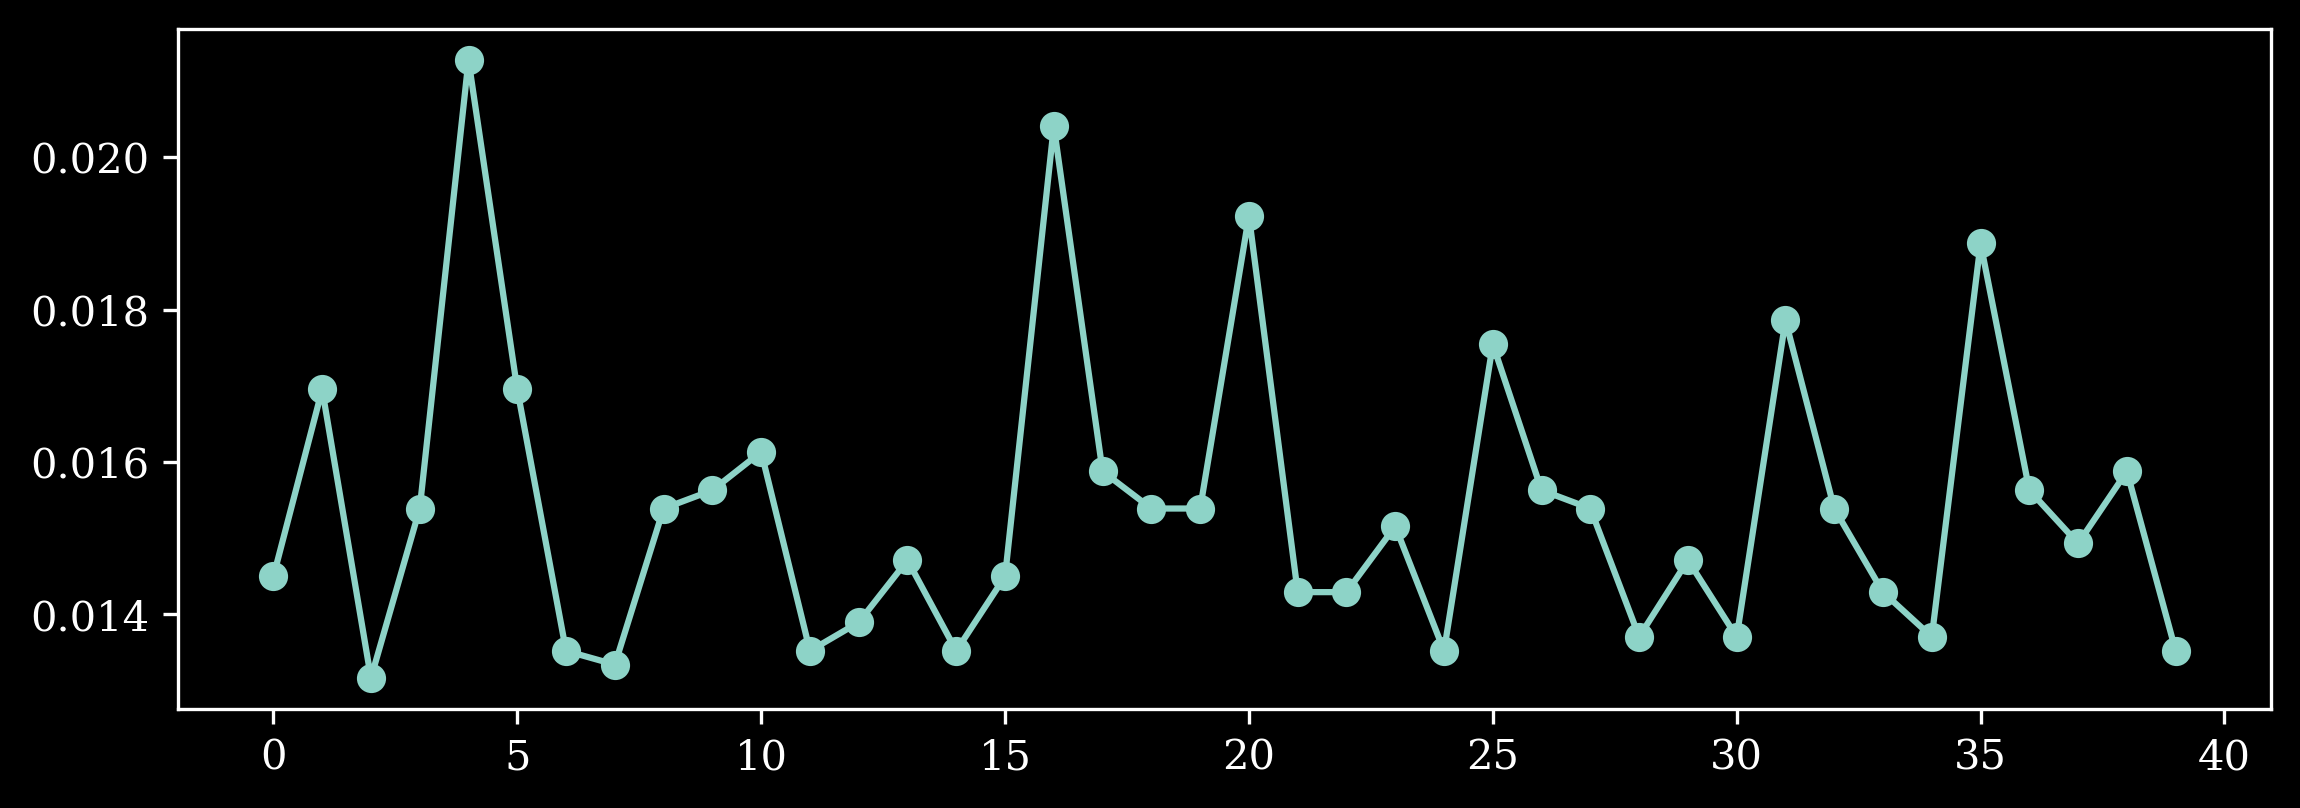

In [37]:
plt.plot(dtTest, marker='o')

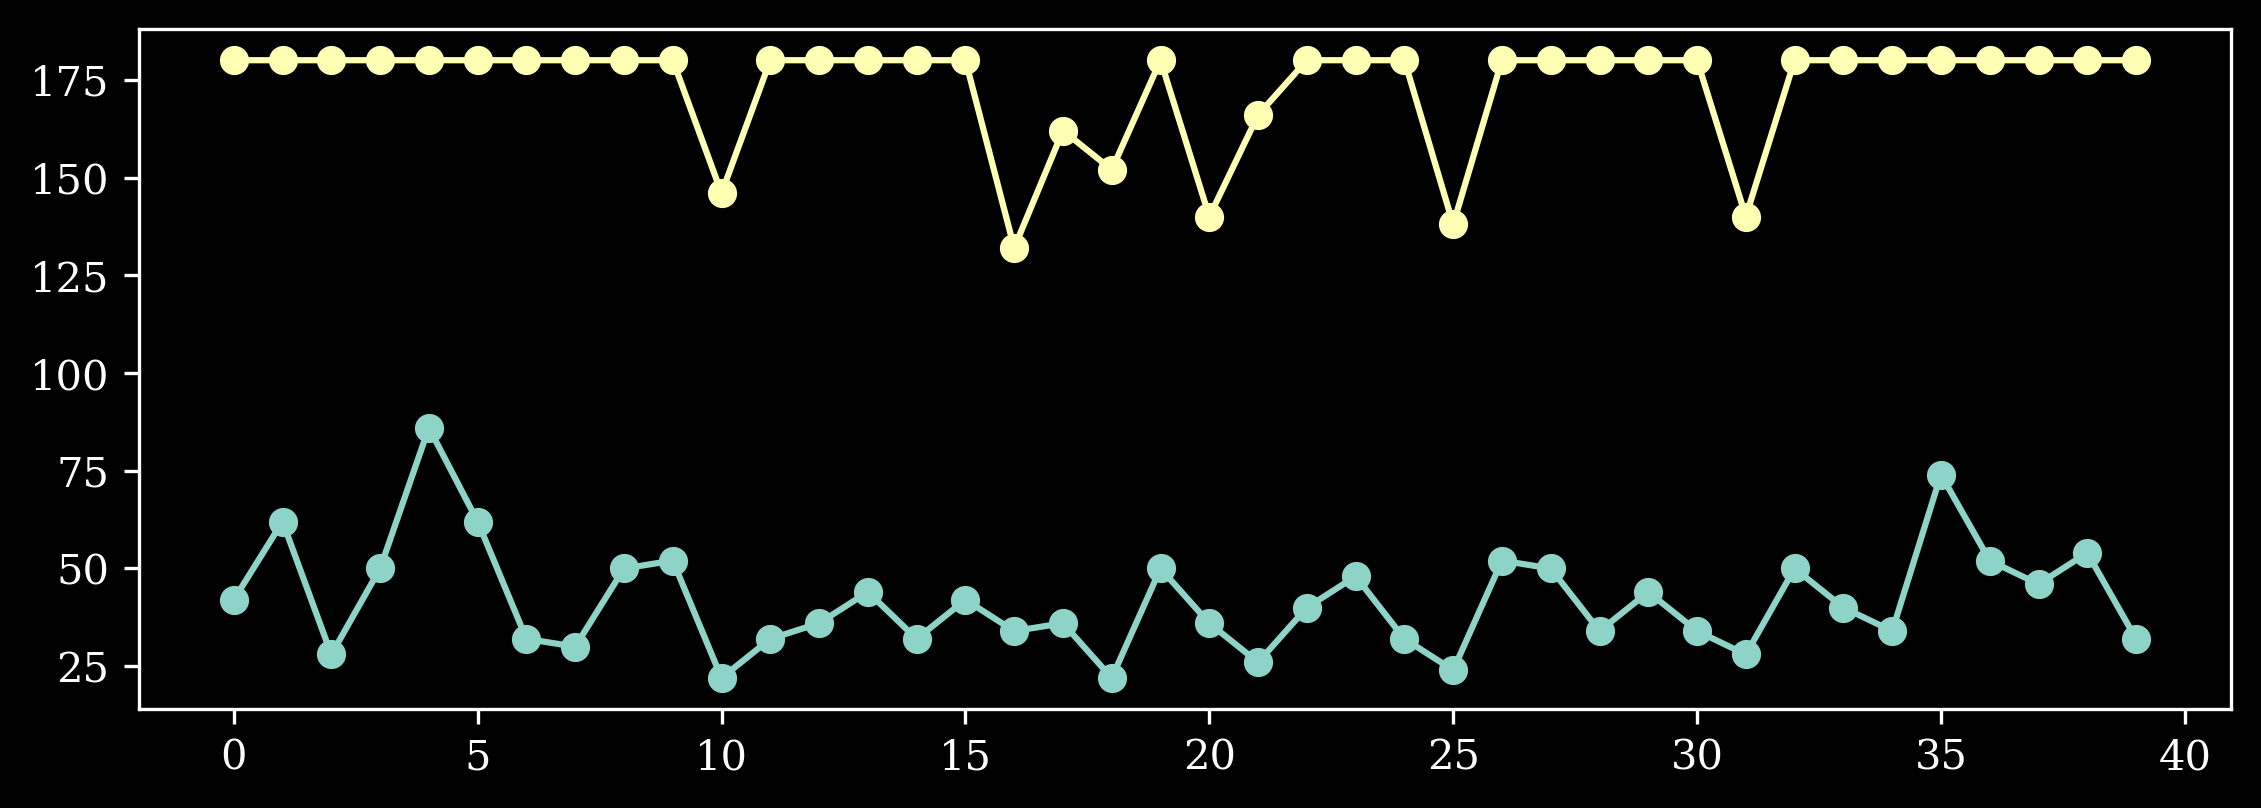

In [38]:
plt.plot(tMinTest, marker='o')
plt.plot(tMaxTest, marker='o')

In [39]:
# NOW NORMALIZE YTRAIN AND YTEST
yMinTrainAll = np.array(yMinTrain).min()
yMaxTrainAll = np.array(yMaxTrain).max()

yMinTrainAll, yMaxTrainAll

(3.765003654922027, 22.359171674874087)

In [40]:
y_train_normalized = (y_train - yMinTrainAll) / (yMaxTrainAll - yMinTrainAll)
y_test_normalized = (y_test - yMinTrainAll) / (yMaxTrainAll - yMinTrainAll)

In [69]:
y_calib_normalized = (y_calib - yMinTrainAll) / (yMaxTrainAll - yMinTrainAll)

In [41]:
y_train_normalized.shape

(90, 40, 183)

In [42]:
# plt.figure(figsize=(6, 6))
# plt.axes(projection = 'polar')

# sidx_to_plot = 0

# times0 = np.arange(tMinTrainIdx[sidx_to_plot], 
#                    tMaxTrainIdx[sidx_to_plot] + 1, 
#                    step=1)

# color = iter(plt.cm.jet(np.linspace(0, 1, len(times0))))

# for i in times0[:20]:
#     cc=next(color)
#     plt.plot(theta_grid * np.pi/180, 
#              y_train_normalized[i, :, sidx_to_plot], 
#              c=cc)
    
# plt.title("After normalization")

In [43]:
# plt.figure(figsize=(6, 6))
# plt.axes(projection = 'polar')

# sidx_to_plot = 0

# times0 = np.arange(tMinTrainIdx[sidx_to_plot], 
#                    tMaxTrainIdx[sidx_to_plot] + 1, 
#                    step=1)

# color = iter(plt.cm.jet(np.linspace(0, 1, len(times0))))

# for i in times0[:20]:
#     cc=next(color)
#     plt.plot(theta_grid * np.pi/180, 
#              y_train[i, :, sidx_to_plot], 
#              c=cc)
    
# plt.title("Before normalization")

In [44]:
cme_params_norm = pd.read_csv("./CMEParams2161_Scaled.csv", index_col=0)
cme_params_norm

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506
...,...,...,...,...,...,...,...,...,...
294,0.8750,0.252834,0.622193,0.1750,0.0,0.363636,0.352593,0.005643,0.937194
295,0.1250,0.655648,0.235434,0.4750,0.0,0.363636,0.352593,0.005643,0.937194
296,0.3250,0.518360,0.245710,0.7750,1.0,0.363636,0.352593,0.005643,0.937194
297,0.9250,0.289994,0.829820,0.6750,0.0,0.363636,0.352593,0.005643,0.937194


In [45]:
cme_params_to_augment = cme_params_norm.to_numpy()
cme_params_to_augment.shape

(278, 9)

In [46]:
cme_params_to_augment_final = np.zeros((cme_params_to_augment.shape[0],
                                       cme_params_to_augment.shape[1] + 1))
cme_params_to_augment_final[:, :(cme_params_to_augment.shape[1])] = cme_params_to_augment


cme_params_to_augment_final[orig_sd_train_idx, cme_params_to_augment.shape[1]] = dtTrain
cme_params_to_augment_final[orig_sd_test_idx, cme_params_to_augment.shape[1]] = dtTest

In [47]:
param_dim = cme_params_to_augment_final.shape[1]
param_dim

10

In [48]:
input_dim = rd_2161.shape[1]
input_dim, param_dim

(40, 10)

In [70]:
augmented_r = np.zeros((rd_2161.shape[0], input_dim + param_dim, rd_2161.shape[2]))
augmented_r[:, :input_dim, orig_sd_train_idx] = y_train_normalized
augmented_r[:, :input_dim, orig_sd_test_idx] = y_test_normalized
augmented_r[:, :input_dim, orig_sd_calib_idx] = y_calib_normalized
for iii in range(rd_2161.shape[2]):
    augmented_r[:, (input_dim):, iii] = cme_params_to_augment_final[iii, :]

In [50]:
aug_y_train = augmented_r[:, :, orig_sd_train_idx]
aug_y_test = augmented_r[:, :, orig_sd_test_idx]

aug_y_train.shape, aug_y_test.shape

((90, 50, 183), (90, 50, 40))

In [51]:
class PNODE(nn.Module):
    def __init__(self, input_dim, param_dim, 
                 n_layers=1, 
                 n_units=90,
                 nonlinear=nn.ELU):
        super(PNODE, self).__init__()

        layers = [nn.Linear(input_dim + param_dim, n_units)]
        
        for i in range(n_layers - 1):
            layers.append(nonlinear())
            layers.append(nn.Linear(n_units, n_units))
            
        layers.append(nonlinear())
        layers.append(nn.Linear(n_units, input_dim))
        
        self.net1 = nn.Sequential(*layers)
        
        # for m in self.net1.modules():
        #     if isinstance(m, nn.Linear):
        #         nn.init.normal_(m.weight, mean=0, std=0.1)
        #         nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        
        output = torch.cat((self.net1(y),
                    torch.zeros_like(y[:, input_dim:])), 
                    -1)
        
        return output

In [52]:
model = PNODE(input_dim,
              param_dim,
              n_layers=args.node_layers,
              n_units=args.units,
              nonlinear=nn.ELU).to(device)

optimizer = optim.Adam(model.parameters(), lr=args.lr)

print(args.lr)

print(edut.count_parameters(model))

print(model)

edut.makedirs(args.save)

if args.load is not None:
    experimentID = args.load
else:
    experimentID = int(SystemRandom().random()*100000)
print(experimentID)

ckpt_path = os.path.join(args.save, "experiment_" + str(experimentID) + '.ckpt')
print(ckpt_path)

0.001
16350
PNODE(
  (net1): Sequential(
    (0): Linear(in_features=50, out_features=70, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=70, out_features=70, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=70, out_features=70, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=70, out_features=40, bias=True)
  )
)
39492
experiments/experiment_39492.ckpt


In [53]:
logger = get_logger(logpath=os.path.join(logdir, "expt_normalized_pnode.log"))
logger

<RootLogger root (INFO)>

In [54]:
logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(edut.count_parameters(model)))
logger.info(vars(args))
logger.info("Train Idx")
logger.info(sd_train)
logger.info("Calib Idx")
logger.info(sd_calib)
logger.info("Test Idx")
logger.info(sd_test)
logger.info("Checkpoint Path")
logger.info(ckpt_path)

/global/u1/a/ajivani/WLROM/EdgeSS
PNODE(
  (net1): Sequential(
    (0): Linear(in_features=50, out_features=70, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=70, out_features=70, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=70, out_features=70, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=70, out_features=40, bias=True)
  )
)
Number of parameters: 16350
{'niters': 200, 'lr': 0.001, 'batch_size': 4, 'batch_time': 5, 'nsims_per_batch': 4, 'nepochs': 250, 'save': 'experiments/', 'load': 39492, 'random_seed': 1123, 'pnode': True, 'node_layers': 3, 'units': 70, 'ds': 4}
Train Idx
[ 31  32  34  37  38  40  41  44  45  46  49  50  51  53  54  56  57  58
  59  61  62  67  69  70  71  72  75  76  77  78  79  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  97  98 101 103 104 105 107 110 111
 112 115 118 120 123 126 127 132 134 135 136 138 139 140 141 143 144 145
 146 147 148 150 151 152 153 154 155 156 157 159 160 161 163 164 166 171


In [55]:
def get_batch_sim(torch_train_data, 
              torch_train_time, 
              # sim_ids = [0, 1, 2, 3, 4], 
              batch_time=4, 
              batch_size=5):
    # by0 = []
    # bt = []
    # by = []
    # s_all = []
    # for sim in sim_ids:
    
    s = torch.from_numpy(np.random.choice(np.arange(len(torch_train_time) - batch_time, dtype=np.int64),
                                          batch_size,
                                          replace=False))
    # batch_y0 = torch_train_data[s, :, sim]  # (M, D)
    
    batch_y0 = torch_train_data[s]  # (M, D)
    # print(batch_y0.shape)
    
    
    batch_t = torch.zeros((batch_size, batch_time))
    for i in range(batch_size):
        batch_t[i, :] = torch_train_time[s[i]:(s[i] + batch_time)]

    batch_y = torch.stack([torch_train_data[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)

    # by0.append(batch_y0)
    # bt.append(batch_t)
    # by.append(batch_y)
    # # s_all.append(s)
        
    return batch_y0, batch_t.to(device), batch_y
    # return batch_y0.to(device), batch_t.to(device), batch_y.to(device)
    # return torch.stack(by0, dim=0).to(device), torch.stack(bt, dim=0).to(device), torch.stack(by,dim=0).to(device), s_all
    # return torch.stack(by0, dim=0).to(device), torch.stack(bt, dim=0).to(device), torch.stack(by,dim=0).to(device)

In [56]:
def get_data_for_sim(sidx, device="cpu"):
    """
    Supply sidx from either orig_sd_train_idx or orig_sd_test_idx
    Based on that, index augmented r dataset, and return relevant training data
    as well as training time.
    """
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = sidx)
    
    valid_times = np.arange(tMin, tMax + 2, step=2)
        
    tAllScaled = (valid_times - tMin) / (tMax - tMin)
    
    r_sim = augmented_r[tMinIdx:(tMaxIdx + 1), :, sidx]
    
    y0_train_torch = torch.from_numpy(np.float32(r_sim[0, :])).reshape((1, len(r_sim[0, :]))).to(device)
    
    t_train_torch = torch.tensor(np.float32(tAllScaled)).to(device)
    
    y_train_torch = torch.from_numpy(np.float32(r_sim)).to(device)
    

    return y0_train_torch, t_train_torch, y_train_torch

In [57]:
# y0t1, tt1, ytt1 = get_data_for_sim(orig_sd_train_idx[0], device=device)
# by01, bt1, by1 = get_batch_sim(ytt1, tt1, batch_size=args.batch_size, batch_time=args.batch_time)

# y0t2, tt2, ytt2 = get_data_for_sim(orig_sd_train_idx[2], device=device)
# by02, bt2, by2 = get_batch_sim(ytt2, tt2, batch_size=args.batch_size, batch_time=args.batch_time)

# by0_combined = torch.stack([by01, by02], dim=0)
# bt_combined = torch.stack([bt1, bt2], dim=0)
# by_combined = torch.stack([by1, by2], dim=0)

# print(by0_combined.shape, bt_combined.shape, by_combined.shape)

# print(model.net1(by0_combined[:, [5], :]).shape, torch.zeros_like(by0_combined[:, [5], input_dim:]).shape)
# print(torch.cat((model.net1(by0_combined[:, [5], :]),
#          torch.zeros_like(by0_combined[:, [5], input_dim:])),
#          -1).shape)
# # model.forward(torch.tensor(0.5), by0_combined[0, [5], :])
# # bt_combined[0, 5, :]
# # odeint(model, by0_combined[0, [5], :], bt_combined[0, 5, :])[:, 0, input_dim:]
# # model(0.2, by0_combined[:, [4], :]).shape

In [58]:
# # TRAIN 2 SIMS ONLY.

# batch_time=4
# batch_size=5
# sim_ids_to_train = [0, 2]

# best_loss = 1e20
# test_freq = 5

# if args.load is not None:
#     ut.get_ckpt_model(ckpt_path, model, device)
# else:
    
#     # get data for sim
#     # y0t = []
#     tt = []
#     ytt = []
#     for i in sim_ids_to_train:
#         _, tt_data, ytt_data = get_data_for_sim(orig_sd_train_idx[i], device=device)
#         # y0t.append(y0_data)
#         tt.append(tt_data)
#         ytt.append(ytt_data)
#         # print("Training data created")
#     for itr in range(1, args.niters + 1):
#         optimizer.zero_grad()

#         by0 = []
#         bt = []
#         byt = []
#         for i, idx in enumerate(sim_ids_to_train):
#             by0_data, bt_data, byt_data = get_batch_sim(ytt[i], 
#                                                         tt[i],
#                                                         batch_time=batch_time,
#                                                         batch_size=batch_size)
#             by0.append(by0_data)
#             bt.append(bt_data)
#             byt.append(byt_data)
            
#         batch_y0 = torch.stack(by0, dim=0)
#         batch_t = torch.stack(bt, dim=0)
#         batch_y = torch.stack(byt, dim=0)
        
#         # print(batch_y0.shape, batch_t.shape, batch_y.shape)
        
#         # stack everything

#         # two loops. outer by sim and inner by batch_size
#         # the timesteps to integrate for are different for different ICs, hence needed
#         # else we can just do odeint on the entire tensor at once.

#         # Predict batch_y and get mean absolute error loss.
#         pred_y = torch.zeros_like(batch_y).to(device)

#         for sim_idx, sim in enumerate(sim_ids_to_train):
#             for i in range(batch_size):
#                 pred_y[sim_idx, :, i, :] = torch.squeeze(odeint(model,
#                                                             batch_y0[sim_idx, [i], :],
#                                                             batch_t[sim_idx, i, :]))

#         loss = torch.mean(torch.abs(pred_y - batch_y))
        
#         # print(loss.item())
#         loss.backward()

#         optimizer.step()

#         if itr % test_freq == 0:
#             bsave = False
#             with torch.no_grad():
                
#                 train_losses = []
                
#                 for sim_idx, sim in enumerate(sim_ids_to_train):
#                     pred_y_train = torch.squeeze(odeint(model,
#                                                         ytt[sim_idx][[0], :],
#                                                         tt[sim_idx]))
                    
#                     train_losses.append(torch.mean(torch.abs(pred_y_train - \
#                                                 ytt[sim_idx])))



#                 message = "Iteration {:04d} | Train loss Sim 1 {:6f} | Train loss Sim 2 {:6f} | Train loss (one batch) {:.6f}|".format(
#                     itr, 
#                     train_losses[0].item(),
#                     train_losses[1].item(),
#                     loss.item())
                
#                 print(message)

#         if itr % 500 == 0:
#             bsave = True
#             if bsave:
#                 print('saving check point...')
#                 torch.save({
#                     'args': args,
#                     'state_dict': model.state_dict(),
#                 }, ckpt_path)

#     if bsave:
#         torch.save({
#             'args': args,
#             'state_dict': model.state_dict(),
#         }, ckpt_path)

In [59]:
### RESULTS OF TRAIN 2 SIMS.
# with torch.no_grad():

#     # yMinTrainAll, yMaxTrainAll
    
#     pred_y_train_1 = torch.squeeze(odeint(model,
#                                         ytt[0][[0], :],
#                                         tt[0])) * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll
    
#     pred_y_train_2 = torch.squeeze(odeint(model,
#                                         ytt[1][[0], :],
#                                         tt[1])) * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll

    
# print(orig_sd_train_idx[sim_ids_to_train])

# tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = orig_sd_train_idx[0])
# r_true_train_1 = augmented_r[tMinIdx:(tMaxIdx + 1), :input_dim, orig_sd_train_idx[0]]

# edut.plotTrainPredData1Model(r_true_train_1 * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll,
#                              pred_y_train_1.cpu()[:, :input_dim],
#                              ed_2161,
#                              sd_2161,
#                              theta=theta_grid,
#                              simIdx=orig_sd_train_idx[sim_ids_to_train[0]],
#                              savefig=False)

# tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = orig_sd_train_idx[2])
# r_true_train_2 = augmented_r[tMinIdx:(tMaxIdx + 1), :input_dim, orig_sd_train_idx[2]]

# edut.plotTrainPredData1Model(r_true_train_2 * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll,
#                              pred_y_train_2.cpu()[:, :input_dim],
#                              ed_2161,
#                              sd_2161,
#                              theta=theta_grid,
#                              simIdx=orig_sd_train_idx[sim_ids_to_train[1]],
#                              savefig=False)

#### Set up training for multiple sims based on defined args.

We will go for more aggressive batch size and batch times. Its better to have 5 representative simulations as validation checks. So the batch in the optimization can keep changing, but we can keep tracking validation loss aggregated over select sims, and we can see if its showing a downward trend.

In [60]:
# from sklearn.utils import shuffle

In [61]:
# # rough estimate of frequency of each sim in np sort 
# sim_ids_all = np.array([i for i in range(len(orig_sd_train_idx))])
# sims_visited = np.array([])
# for i in range(250):
#     sims_visited = np.append(sims_visited, np.sort(rng.choice(sim_ids_all, args.nsims_per_batch, replace=False)))
    
# unique_sims, counts = np.unique(sims_visited, return_counts=True)

# print(len(unique_sims))

# plt.hist(sims_visited, bins=len(sim_ids_all));

In [62]:
len(orig_sd_train_idx)

183

In [63]:
device

device(type='cuda', index=0)

In [64]:
torch.backends.cudnn.benchmark = True
batch_time=args.batch_time
batch_size=args.batch_size
# sim_ids_to_train = [0, 2]
sim_ids_all = np.array([i for i in range(len(orig_sd_train_idx))])
sim_ids_to_track = [0, 1, 2, 3, 4]
test_freq = 5
ckpt_freq = args.niters

logger.info("Test freq {}".format(test_freq))
logger.info("Checkpoint freq {}".format(ckpt_freq))


train_batch_losses = []
val_sim_losses_agg = []

tt_val = []
ytt_val = []
for i in sim_ids_to_track:
    _, tt_data, ytt_data = get_data_for_sim(orig_sd_track_idx[i], device=device)
    # y0t.append(y0_data)
    tt_val.append(tt_data)
    ytt_val.append(ytt_data)


if args.load is not None:
    edut.get_ckpt_model(ckpt_path, model, device)
# else:
    # for ep in range(1, args.nepochs + 1):
    for ep in range(177, args.nepochs + 1): # start from 1 normally, here we are warmstarting from checkpoint
        sim_ids_to_train = np.sort(rng.choice(sim_ids_all, args.nsims_per_batch, replace=False))
        tt = []
        ytt = []
        for i in sim_ids_to_train:
            _, tt_data, ytt_data = get_data_for_sim(orig_sd_train_idx[i], device=device)
            # y0t.append(y0_data)
            tt.append(tt_data)
            ytt.append(ytt_data)

        for itr in range(1, args.niters + 1):
            optimizer.zero_grad()

            by0 = []
            bt = []
            byt = []
            for i, idx in enumerate(sim_ids_to_train):
                by0_data, bt_data, byt_data = get_batch_sim(ytt[i], 
                                                            tt[i],
                                                            batch_time=batch_time,
                                                            batch_size=batch_size)
                by0.append(by0_data)
                bt.append(bt_data)
                byt.append(byt_data)

            batch_y0 = torch.stack(by0, dim=0)
            batch_t = torch.stack(bt, dim=0)
            batch_y = torch.stack(byt, dim=0)

            # print(batch_y0.shape, batch_t.shape, batch_y.shape)

            # stack everything

            # two loops. outer by sim and inner by batch_size
            # the timesteps to integrate for are different for different ICs, hence needed
            # else we can just do odeint on the entire tensor at once.

            # Predict batch_y and get mean absolute error loss.
            pred_y = torch.zeros_like(batch_y).to(device)

            for sim_idx, sim in enumerate(sim_ids_to_train):
                for i in range(batch_size):
                    pred_y[sim_idx, :, i, :] = torch.squeeze(odeint(model,
                                                                batch_y0[sim_idx, [i], :],
                                                                batch_t[sim_idx, i, :]))

            loss = torch.mean(torch.abs(pred_y - batch_y))

            loss.backward()
            optimizer.step()

            train_batch_losses.append(loss.item())

            if itr % test_freq == 0:
                bsave = False
                with torch.no_grad():

                    running_loss = 0.0

                    for sim_idx, sim in enumerate(sim_ids_to_track):
                        pred_y_val = torch.squeeze(odeint(model,
                                                        ytt_val[sim_idx][[0], :],
                                                        tt_val[sim_idx]))

                        val_loss = torch.mean(torch.abs(pred_y_val - \
                                                    ytt_val[sim_idx]))
                    
                        running_loss += val_loss.item()
                    

                    val_sim_losses_agg.append(running_loss)

                    message = "Epoch {:02d}|Iteration {:03d}|Val Losses Agg {:.6f}|Train loss batch {:.6f}|".format(
                        ep,
                        itr, 
                        running_loss,
                        loss.item())

                    # print(message)
                    logger.info(message)

            if itr % ckpt_freq == 0:
                bsave = True
                if bsave:
                    # print('saving check point...')
                    logger.info("saving check point...")
                    torch.save({
                        'args': args,
                        'state_dict': model.state_dict(),
                    }, ckpt_path)

Test freq 5
Checkpoint freq 200
Epoch 177|Iteration 005|Val Losses Agg 0.170005|Train loss batch 0.002783|
Epoch 177|Iteration 010|Val Losses Agg 0.176106|Train loss batch 0.002935|
Epoch 177|Iteration 015|Val Losses Agg 0.153484|Train loss batch 0.002638|
Epoch 177|Iteration 020|Val Losses Agg 0.148268|Train loss batch 0.002031|
Epoch 177|Iteration 025|Val Losses Agg 0.145447|Train loss batch 0.002440|
Epoch 177|Iteration 030|Val Losses Agg 0.143401|Train loss batch 0.002426|
Epoch 177|Iteration 035|Val Losses Agg 0.142919|Train loss batch 0.002616|
Epoch 177|Iteration 040|Val Losses Agg 0.147160|Train loss batch 0.001995|
Epoch 177|Iteration 045|Val Losses Agg 0.147013|Train loss batch 0.002909|
Epoch 177|Iteration 050|Val Losses Agg 0.142417|Train loss batch 0.002454|
Epoch 177|Iteration 055|Val Losses Agg 0.139004|Train loss batch 0.002710|
Epoch 177|Iteration 060|Val Losses Agg 0.137280|Train loss batch 0.001907|
Epoch 177|Iteration 065|Val Losses Agg 0.139436|Train loss batch 0.0

In [76]:
with torch.no_grad():

    # yMinTrainAll, yMaxTrainAll
    
    sim_ids_all_test = np.array([i for i in range(len(orig_sd_test_idx))])
    
    for sim_id in sim_ids_all_test:
    
        _, tt_data, ytt_data = get_data_for_sim(orig_sd_test_idx[sim_id], device=device)
    
        pred_y_test = torch.squeeze(odeint(model,
                                        ytt_data[[0], :],
                                        tt_data)) * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll
    

        print(sim_id)

        tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = orig_sd_test_idx[sim_id])
        r_true = augmented_r[tMinIdx:(tMaxIdx + 1), :input_dim, orig_sd_test_idx[sim_id]] * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll

        edut.plotTrainPredData1Model(r_true,
                                     pred_y_test.cpu()[:, :input_dim],
                                     ed_2161,
                                     sd_2161,
                                     theta=theta_grid,
                                     simIdx=orig_sd_test_idx[sim_id],
                                     savefig=True,
                                     savedir="./test_sim_figs_global_NODE")

0
Saved image for Sim 035
1
Saved image for Sim 043
2
Saved image for Sim 066
3
Saved image for Sim 068
4
Saved image for Sim 081
5
Saved image for Sim 096
6
Saved image for Sim 099
7
Saved image for Sim 106
8
Saved image for Sim 108
9
Saved image for Sim 114
10
Saved image for Sim 119
11
Saved image for Sim 122
12
Saved image for Sim 124
13
Saved image for Sim 133
14
Saved image for Sim 158
15
Saved image for Sim 174
16
Saved image for Sim 181
17
Saved image for Sim 186
18
Saved image for Sim 188
19
Saved image for Sim 194
20
Saved image for Sim 200
21
Saved image for Sim 208
22
Saved image for Sim 212
23
Saved image for Sim 237
24
Saved image for Sim 244
25
Saved image for Sim 248
26
Saved image for Sim 256
27
Saved image for Sim 257
28
Saved image for Sim 258
29
Saved image for Sim 266
30
Saved image for Sim 267
31
Saved image for Sim 268
32
Saved image for Sim 277
33
Saved image for Sim 279
34
Saved image for Sim 287
35
Saved image for Sim 292
36
Saved image for Sim 302
37
Saved im

In [ ]:
# sd_test

In [ ]:
# torch.save({'args': args,
#             'state_dict': model.state_dict(),
#             }, ckpt_path)

**Conformalized Predictions**

In [71]:
orig_sd_calib_idx = np.array([np.where(sd_2161 == i)[0][0] for i in sd_calib])

scores = []

with torch.no_grad():

    # yMinTrainAll, yMaxTrainAll
    
    sim_ids_all_calib = np.array([i for i in range(len(orig_sd_calib_idx))])
    
    for sim_id in sim_ids_all_calib:
    
        _, tt_data, ytt_data = get_data_for_sim(orig_sd_calib_idx[sim_id], device=device)
    
        pred_y_calib = torch.squeeze(odeint(model,
                                        ytt_data[[0], :],
                                        tt_data)) * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll
    
        scores.append(torch.mean(torch.abs(pred_y_calib - (ytt_data * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll))).item())
        print(sim_id)

        # tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx = orig_sd_test_idx[sim_id])
        # r_true = augmented_r[tMinIdx:(tMaxIdx + 1), :input_dim, orig_sd_test_idx[sim_id]] * (yMaxTrainAll - yMinTrainAll) + yMinTrainAll

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [72]:
scores

[0.506319522857666,
 1.0012081861495972,
 1.3690389394760132,
 1.6391355991363525,
 0.3319915235042572,
 0.2783850133419037,
 2.4236207008361816,
 3.5876212120056152,
 0.5302484035491943,
 0.6874138116836548,
 1.3181757926940918,
 1.591491937637329,
 0.6319116353988647,
 1.4581226110458374,
 2.415046453475952,
 2.0321691036224365,
 5.184138774871826,
 0.9343780875205994,
 4.962402820587158,
 1.1896040439605713,
 1.8247554302215576,
 0.6201084852218628,
 1.7047542333602905,
 0.23206205666065216,
 0.4924982786178589,
 1.7790911197662354,
 1.2335559129714966,
 0.23391485214233398,
 1.5346965789794922,
 1.8672685623168945,
 1.6008422374725342,
 2.2860732078552246,
 1.860539197921753,
 3.269237518310547,
 0.307586669921875,
 3.1448137760162354,
 2.5793702602386475,
 0.9169696569442749,
 0.42950841784477234]

In [73]:
alpha_cov = 0.9
scores_quant = np.quantile(scores, q=alpha_cov)

In [74]:
scores_quant

3.169698524475098

In [75]:
# calculate intervals on test images.